# Clustering of receptor sequences

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import glob
import numpy as np
# import editdistance
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr, kendalltau, rankdata
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE as TSNE
import seaborn as sns
from math import ceil
import gzip
import pandas as pd
import time
import math
from sklearn.metrics.pairwise import pairwise_distances
import gzip
import pickle
import re
from sklearn.cluster import DBSCAN, KMeans
from collections import Counter
from sklearn.metrics import silhouette_score
import os

print(plt.style.available)
plt.style.use('seaborn-whitegrid')

['seaborn-ticks', 'ggplot', 'seaborn-darkgrid', 'seaborn-colorblind', 'seaborn-paper', 'seaborn-notebook', 'seaborn-white', 'seaborn-talk', 'seaborn-dark', 'seaborn-bright', 'fivethirtyeight', 'seaborn-poster', 'seaborn-pastel', 'classic', 'seaborn-dark-palette', 'grayscale', 'dark_background', 'seaborn-muted', 'seaborn-deep', 'bmh', 'seaborn-whitegrid']


In [4]:
print(np.load("Gen_test_levenshtein.npz").files)
np.load("Gen_test_levenshtein.npz")["dist10"]

['dist10', 'inds10', 'inds5', 'dist5', 'inds20', 'dist20']


array([ 21.,  28.,  28., ...,  42.,  50.,  47.])

In [11]:
# def load_embeds(filename):
#     nparr = np.load(filename)
#     return nparr["seq"], nparr["emb"]

# def embed_dist(emb_vec, mat_file, indices, K):
#     old_dist = np.load(mat_file)["dist" + str(K)][indices] / K
#     inds_vec = np.load(mat_file)["inds" + str(K)][indices]
    
#     res = []
#     for i in range(old_dist.shape[0]):
#         res.append((pairwise_distances(emb_vec[i].reshape((1, -1)), emb_vec[inds_vec[i]], metric="euclidean")).mean())
#     new_dist = np.array(res)

#     corS = spearmanr(new_dist, old_dist)
#     corP = pearsonr(new_dist, old_dist)
#     corK = kendalltau(new_dist, old_dist)
    
#     return new_dist, old_dist, corS, corP, corK

In [2]:
filename = "../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_mse_loglev/embeddings.npz"
df = np.load(filename)["emb"]
seq_names = np.load(filename)["seq"]

np.random.seed(42)
ind = np.random.choice(np.arange(20000), size=16000, replace=False)
ind_1 = ind[:8000]
ind_2 = ind[8000:]

a1_embed = df[ind_1, :].astype(np.float64)
a2_embed = df[ind_2, :].astype(np.float64)

a1_seq = seq_names[ind_1]
a2_seq = seq_names[ind_2]

print(a1_embed.shape)
print(a2_embed.shape)

(8000, 30)
(8000, 30)


In [7]:
import time
import Levenshtein
import multiprocessing as mp

seq_all = seq_names[ind]

def compute_lev(args):
    i, j = args
    return Levenshtein.distance(seq_all[i], seq_all[j])

start_time = time.time()

lev_mat = np.zeros((a1_embed.shape[0] + a2_embed.shape[0], a1_embed.shape[0] + a2_embed.shape[0]))
    

def gen_pairs(lev_mat):
    for i in range(lev_mat.shape[0] - 1):
        for j in range(i+1, lev_mat.shape[0]):
            yield (i,j)

    
print("Distance matrix")
with mp.Pool(4) as pool:
    pairs = []
    res = pool.map(compute_lev, gen_pairs(lev_mat))
    del pairs
    
print("Finalizing the matrix")
k = 0
for i in range(lev_mat.shape[0] - 1):
    for j in range(i+1, lev_mat.shape[0]):
        lev_mat[i, j] = res[k]
        lev_mat[j, i] = res[k]
        k += 1
        
print(time.time() - start_time)

Distance matrix
Finalizing the matrix
115.85555481910706


In [8]:
# from sklearn.manifold import MDS

# start_time = time.time()

# lev_mds = MDS(n_components=30, n_jobs=1, metric=True, dissimilarity="precomputed").fit_transform(lev_mat)
# with open("lev_mds.npz", "wb") as outf:
#     np.savez_compressed(outf, lev_mds = lev_mds)
    
# lev_mds_nm = MDS(n_components=30, n_jobs=1, metric=False, dissimilarity="precomputed").fit_transform(lev_mat)
# with open("lev_mds_nm.npz", "wb") as outf:
#     np.savez_compressed(outf, lev_mds_nm = lev_mds_nm)
    
# print(time.time() - start_time)

lev_mds = np.load("lev_mds.npz")["lev_mds"]
lev_mds.shape

(16000, 30)

In [13]:
def par_compute_tsne(args):
    perp, metric, data = args
    if metric:
        tsne = TSNE(perplexity=perp, metric=metric)
    else:
        tsne = TSNE(perplexity=perp)
    print("!", end="")
    return tsne.fit_transform(data)

start_time = time.time()

with mp.Pool(4) as pool:
    tsne_pars = []
    tsne_pars.append((5, "", np.vstack([a1_embed, a2_embed])))
    tsne_pars.append((20, "", np.vstack([a1_embed, a2_embed])))
    tsne_pars.append((60, "", np.vstack([a1_embed, a2_embed])))
    tsne_pars.append((100, "", np.vstack([a1_embed, a2_embed])))
    tsne_pars.append((5, "precomputed", lev_mat))
    tsne_pars.append((20, "precomputed", lev_mat))
    tsne_pars.append((60, "precomputed", lev_mat))
    tsne_pars.append((100, "precomputed", lev_mat))
    tsne_pars.append((5, "", lev_mds))
    tsne_pars.append((20, "", lev_mds))
    tsne_pars.append((60, "", lev_mds))
    tsne_pars.append((100, "", lev_mds))
    res = pool.map(par_compute_tsne, tsne_pars[::-1])[::-1]
    
    emb_tsne = res[:4]
    lev_tsne = res[4:8]
    mds_tsne = res[8:]
    
print()
print(time.time() - start_time)
# 900


0.12518095970153809


In [10]:
def get_lev_ranks(lev_mat, K=[2, 3, 5, 8, 10, 12, 15, 20]):
    if type(K) is not list:
        K = [K]
        
    dist_res = {k:np.zeros((lev_mat.shape[0],  )) for k in K}
    ind_res  = {k:np.zeros((lev_mat.shape[0], k+1), dtype=np.int) for k in K}
    
    print("Distance analysis")
    for k in K:
        for i in range(lev_mat.shape[0]):
            ind_res[k][i]  = np.sort(np.argpartition(lev_mat[i], k+1)[:k+1])
            dist_res[k][i] = lev_mat[i, ind_res[k][i]].sum()
            
    return dist_res, ind_res

lev_ranks = get_lev_ranks(lev_mat)

Distance analysis


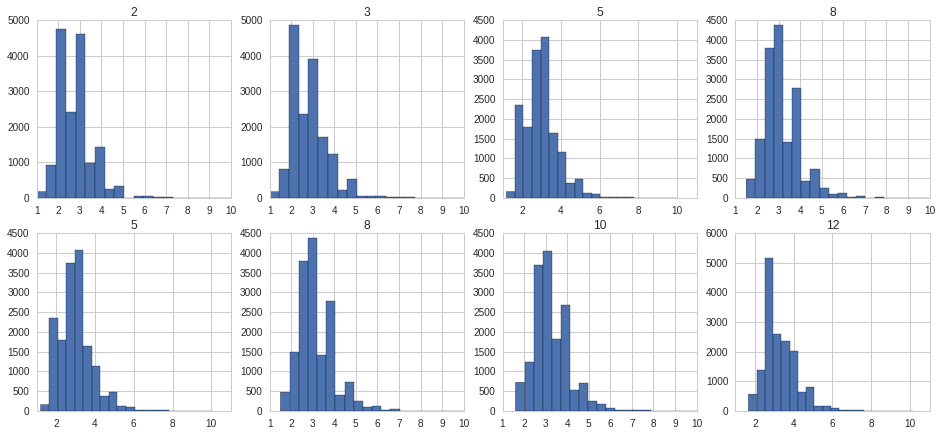

In [26]:
K_list = [2, 3, 5, 8, 10, 12, 15, 20]

fig, ax = plt.subplots(2, 4)
fig.set_figheight(7)
fig.set_figwidth(16)

for i in range(2):
    for j in range(4):
        _ = ax[i][j].hist(lev_ranks[0][K_list[i*2 + j]] / K_list[i*2 + j], bins=20)
        ax[i][j].set_title(K_list[i*2 + j])

In [79]:
def embed_dist(emb_vec, dist_res, ind_res, K):
    old_dist = dist_res[K] / K
    inds_vec = ind_res[K]
    
    res = []
    for i in range(old_dist.shape[0]):
        res.append((pairwise_distances(emb_vec[i].reshape((1, -1)), emb_vec[inds_vec[i]], metric="euclidean")).mean())
    new_dist = np.array(res)

#     corS = spearmanr(new_dist, old_dist)
#     corP = pearsonr(new_dist, old_dist)
    corK = kendalltau(new_dist, old_dist)
    
    return new_dist, old_dist, corK[0]

lev_Ks = []
emb_Ks = []
siam_Ks = []
mds_Ks = []
for K in K_list:
    print(K)
    for i in range(0, len(emb_tsne)):
        lev_Ks.append(embed_dist(lev_tsne[i], lev_ranks[0], lev_ranks[1], K)[2])
        emb_Ks.append(embed_dist(emb_tsne[i], lev_ranks[0], lev_ranks[1], K)[2])
    siam_Ks.append(embed_dist(np.vstack([a1_embed, a2_embed]), lev_ranks[0], lev_ranks[1], K)[2])
    mds_Ks.append(embed_dist(lev_mds, lev_ranks[0], lev_ranks[1], K)[2])
        
print(sorted(lev_Ks, reverse=True)[:4])
print(sorted(emb_Ks, reverse=True)[:4])
print(sorted(siam_Ks, reverse=True)[:4])
print(sorted(mds_Ks, reverse=True)[:4])

2
3
5
8
10
12
15
20
[0.22998544999384801, 0.22581766078950821, 0.2198817747725399, 0.21589306233139757]
[0.20476282332198736, 0.20290940280980321, 0.20037485734077262, 0.19691825170932284]
[0.38731072853631721, 0.3844190839151515, 0.38368853238468115, 0.38170844104653523]
[0.77929370484019089, 0.76871946256364132, 0.76215364174876754, 0.75755390399993749]


In [80]:
K_lev = K_list[lev_Ks.index(sorted(lev_Ks)[-1]) // len(lev_tsne)]
K_emb = K_list[emb_Ks.index(sorted(emb_Ks)[-1]) // len(emb_tsne)]

res_i_lev = lev_Ks.index(sorted(lev_Ks)[-1]) % len(lev_tsne)
rev_i_emb = emb_Ks.index(sorted(emb_Ks)[-1]) % len(emb_tsne)

print((sorted(emb_Ks)[-1] - sorted(lev_Ks)[-1]) / sorted(lev_Ks)[-1] * 100)

-10.9670532082


In [101]:
def plot_clusters3(res, labels, ax, legend=False, psize=4, alpha=1):
    labels = np.array(labels)
    
    colors = ["black", "dodgerblue", "orange", "red"]

    for i, uniq_len in enumerate(sorted(set(labels))):
        if uniq_len == 0:
            ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, s=psize, alpha=alpha, c=colors[i])
        else:
            ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, s=psize*4, alpha=1, c=colors[i])
    
#     ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, s=psize*4, alpha=1)
    

#     colormap = plt.cm.RdBu #gist_ncar, nipy_spectral, Set1, Paired  
#     colorst = [colormap(i+.3) for i in np.linspace(-.8, 1.7, len(ax.collections))]

#     colormap = plt.cm.nipy_spectral #gist_ncar, nipy_spectral, Set1, Paired  
#     colorst = [colormap(i+.2) for i in np.linspace(-.8, 1.7, len(ax.collections))]

#     for t, j1 in enumerate(ax.collections):
#         j1.set_color(colorst[t])

    if legend:
        ax.legend()

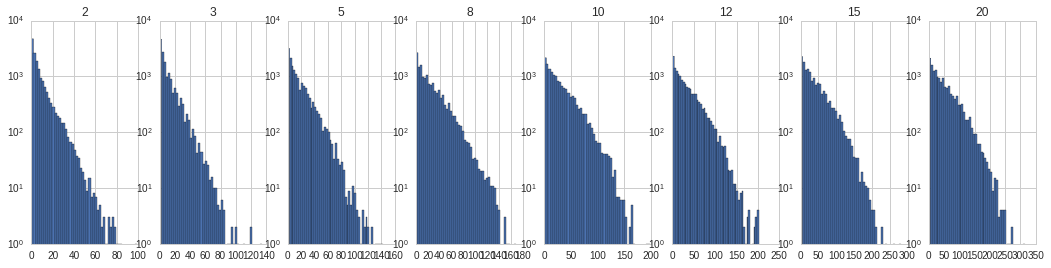

In [139]:
fig, ax = plt.subplots(1, len(K_list))
fig.set_figheight(4)
fig.set_figwidth(18)

for i, K in enumerate(K_list):
    num_neis = []
    for i_source in range(16000):
        i_targets = lev_ranks[1][K][i_source]
        i_others = np.array(list(set(np.where(lev_mat[i_source] <= lev_mat[i_source, lev_ranks[1][K][i_source]].max())[0]).difference(set(lev_ranks[1][K][i_source]))))
        num_neis.append(len(i_others))
    _ = ax[i].hist(num_neis, bins=50)
    ax[i].set_yscale('log', nonposy='clip')
    ax[i].set_title(K)

8


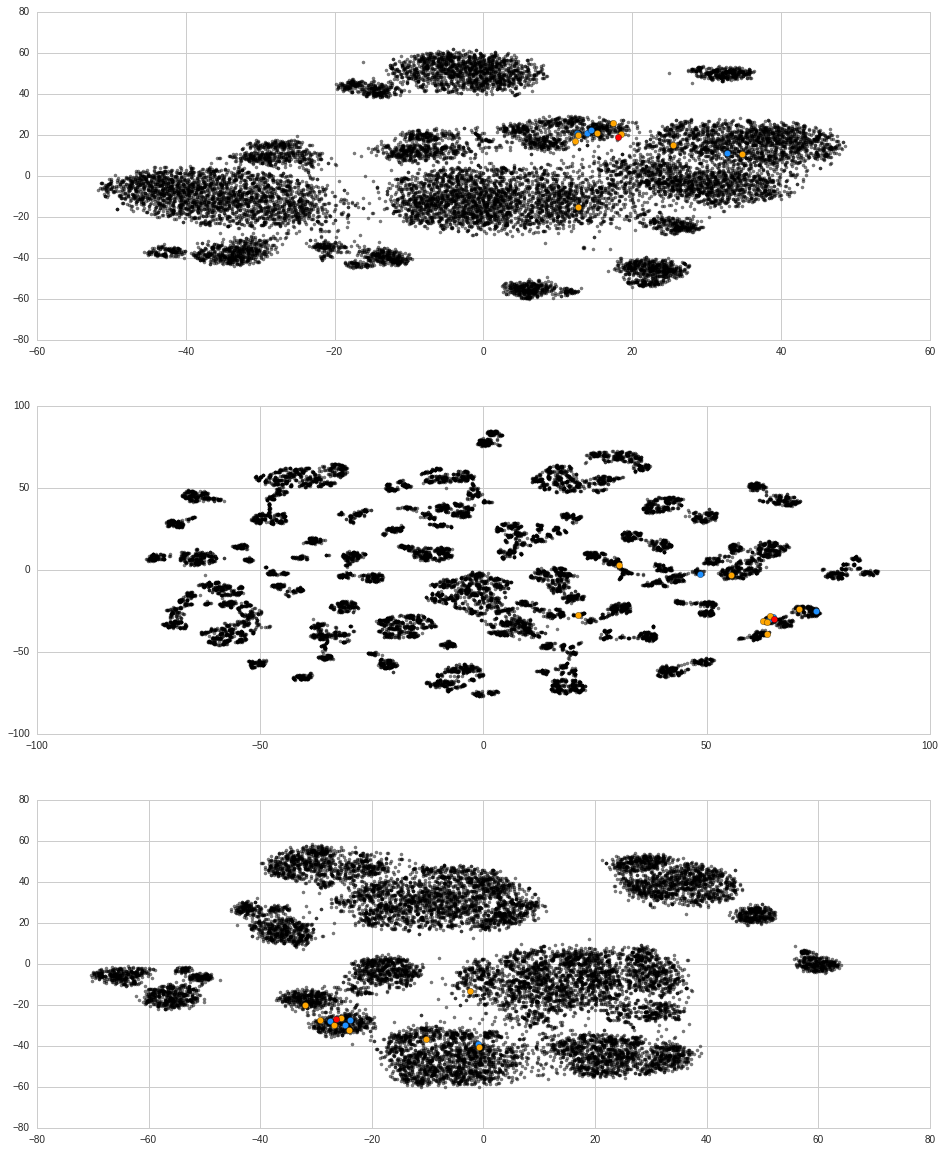

In [128]:
fig, ax = plt.subplots(3, 1)
fig.set_figheight(20)
fig.set_figwidth(16)

K = 5
# i_source = 400 - очень много соседей
i_source = 800
i_targets = lev_ranks[1][K][i_source]
i_others = np.array(list(set(np.where(lev_mat[i_source] <= lev_mat[i_source, lev_ranks[1][K][i_source]].max())[0]).difference(set(lev_ranks[1][K][i_source]))))
print(len(i_others))
vec = np.zeros((a1_embed.shape[0] + a2_embed.shape[0], ))
vec[i_targets], vec[i_others], vec[i_source] = 1,2,3
plot_clusters3(lev_tsne[2], vec, ax[0], False, 10, alpha=.5)
plot_clusters3(emb_tsne[2], vec, ax[1], False, 10, alpha=.5)
plot_clusters3(mds_tsne[2], vec, ax[2], False, 10, alpha=.5)

In [ ]:
# plot_clusters3(lev_tsne[0], 
#                np.hstack([[len(x) for x in a1_seq], [len(x) for x in a2_seq]]), 
#                ax[0], False, 10, alpha=.5)

# plot_clusters3(emb_tsne[0], 
#                np.hstack([[len(x) for x in a1_seq], [len(x) for x in a2_seq]]), 
#                ax[1], False, 10, alpha=.5)

# font_size = 20
# ax[0].set_title("t-SNE на расстояние Левенштейна")
# ax[0].title.set_fontsize(font_size)
# ax[1].set_title("Предложенная методика")
# ax[1].title.set_fontsize(font_size)

# ax[1].set_xlim([-100, 100])
# ax[1].set_ylim([-100, 100])
# ax[0].set_ylim(lims)
# ax[1].set_xlim(lims)
# ax[1].set_ylim([-60])

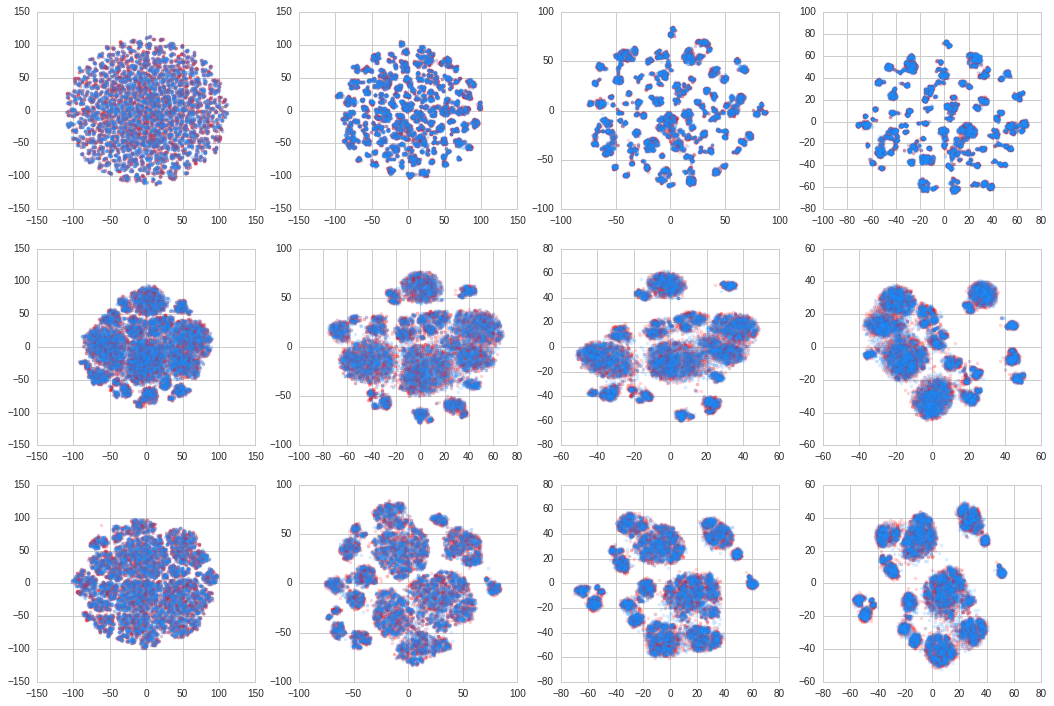

In [18]:
def plot_clusters2(res, labels, ax, legend=False, psize=4, alpha=1):
    labels = np.array(labels)

    for i, uniq_len in enumerate(set(labels)):
        ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, 
                   s=psize, alpha=alpha, color=["red", "dodgerblue"][i])

    if legend:
        ax.legend()
        

fig, ax = plt.subplots(3, 4)
fig.set_figheight(12)
fig.set_figwidth(18)

for i in range(4):
    plot_clusters2(res[i],
           np.hstack([["A1" for _ in range(a1_embed.shape[0])], ["A2" for _ in range(a2_embed.shape[0])]]), 
           ax[0][i], False, 10, alpha=.15)
        
for i in range(4):
    plot_clusters2(res[4+i],
           np.hstack([["A1" for _ in range(a1_embed.shape[0])], ["A2" for _ in range(a2_embed.shape[0])]]), 
           ax[1][i], False, 10, alpha=.15)
    
for i in range(4):
    plot_clusters2(res[8+i],
           np.hstack([["A1" for _ in range(a1_embed.shape[0])], ["A2" for _ in range(a2_embed.shape[0])]]), 
           ax[2][i], False, 10, alpha=.15)


# ax.set_title("t-SNE")
# ax.set_xlim([-60, 60])
# ax.set_ylim([-60, 60])

In [59]:
def plot_clusters(res, labels, ax, legend=False, psize=4, alpha=1, title=None):
    labels = np.array(labels)

    for uniq_len in set(labels):
        ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, s=psize, alpha=alpha)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1, Paired  
    colorst = [colormap(i) for i in np.linspace(0, .9, len(ax.collections))]

    for t, j1 in enumerate(ax.collections):
        j1.set_color(colorst[t])

    if legend:
        ax.legend()
        
    if title:
        ax.set_title(title)

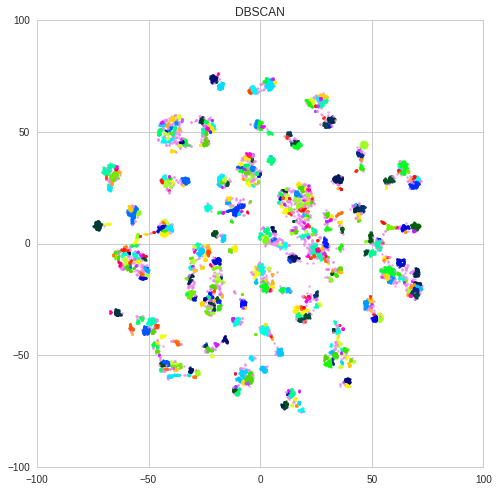

In [62]:
from sklearn.cluster import DBSCAN

res_cl1 = DBSCAN(eps=.6, n_jobs=-1).fit_predict(res[4])

fig, ax = plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(8)

plot_clusters(res[4], res_cl1, ax, legend=False, alpha=.8)

ax.set_title("DBSCAN")
# ax.set_xlim([-60, 60])
# ax.set_ylim([-60, 60])

In [ ]:
sequences = np.hstack([a1_seq, a2_seq])
for clust_ind in set(res_cl1):
    if clust_ind != -1:
        subset = sequences[res_cl1 == clust_ind]
        if len(subset) < 10:
            for x in sorted(subset):
                print(x)
            print("---")